## Imports / Setup

In [98]:
import pandas as pd
import kagglehub
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.base import clone
import plotly.graph_objects as go




from flaml import AutoML

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import tabulate
import seaborn as sns
import time


In [2]:

# Download latest version
path = kagglehub.dataset_download("pavansubhasht/ibm-hr-analytics-attrition-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset/versions/1


In [3]:
df = pd.read_csv(path + "/WA_Fn-UseC_-HR-Employee-Attrition.csv")
pd.set_option('display.max_columns', None)

## Data Preprocessing

In [4]:
# Check for missing / invalid values
print(df.isna().sum().sum())
print(df.isnull().sum().sum())

0
0


In [5]:
df

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,3,Male,41,4,2,Laboratory Technician,4,Married,2571,12290,4,Y,No,17,3,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,4,Male,42,2,3,Healthcare Representative,1,Married,9991,21457,4,Y,No,15,3,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,2,Male,87,4,2,Manufacturing Director,2,Married,6142,5174,1,Y,Yes,20,4,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,4,Male,63,2,2,Sales Executive,2,Married,5390,13243,2,Y,No,14,3,4,80,0,17,3,2,9,6,0,8


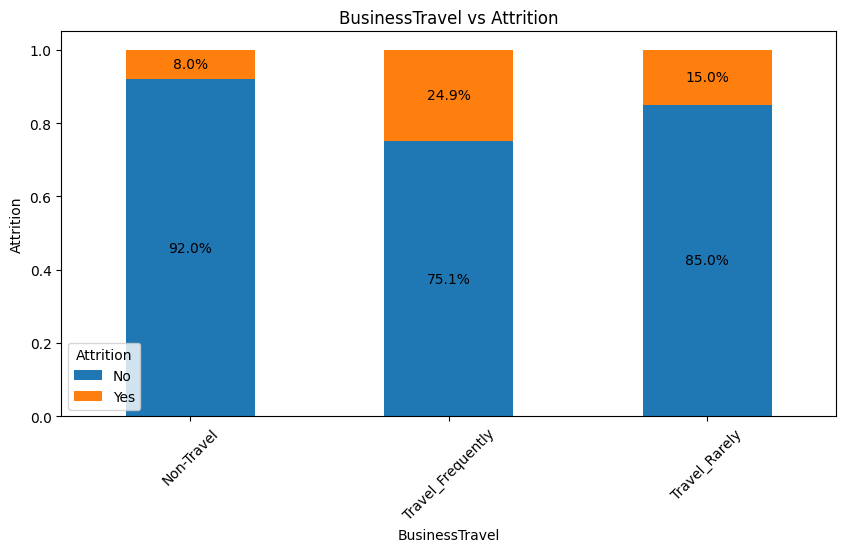

In [6]:
## Lets analyze some relations to gain insight between some protected class parameters and attrition

def plot_attrition(column):

  attrition_counts = pd.crosstab(df[column], df['Attrition'])
  attrition_percentages = attrition_counts.div(attrition_counts.sum(axis=1), axis=0)
  ax = attrition_percentages.plot(kind='bar', stacked=True, figsize=(10, 5))
  for container in ax.containers:
      labels = [f'{w:.1%}' if (w := v.get_height()) > 0 else '' for v in container]
      ax.bar_label(container, labels=labels, label_type='center')


  plt.title(column + ' vs Attrition')
  plt.xlabel(column)
  plt.xticks(rotation = 45)
  plt.ylabel('Attrition')
  plt.show()


plot_attrition('BusinessTravel')

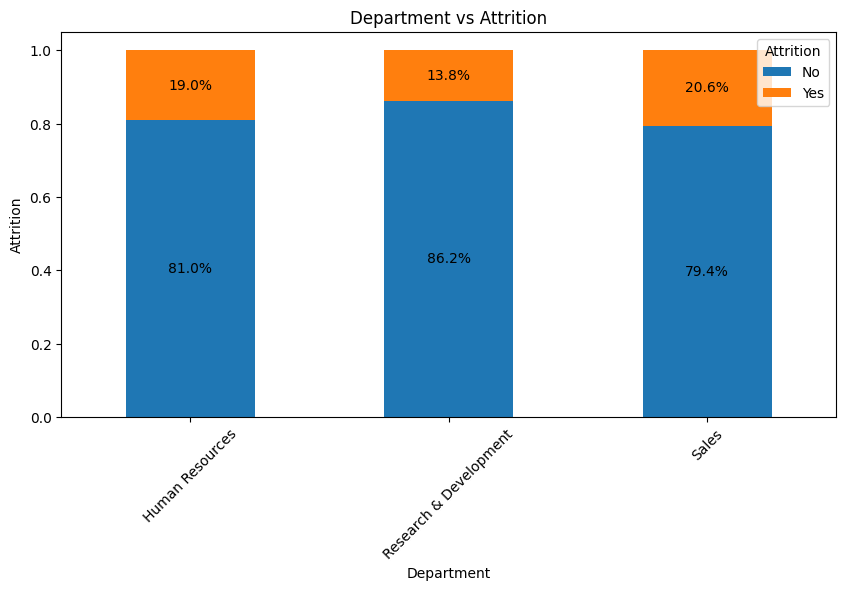

In [7]:
plot_attrition('Department')

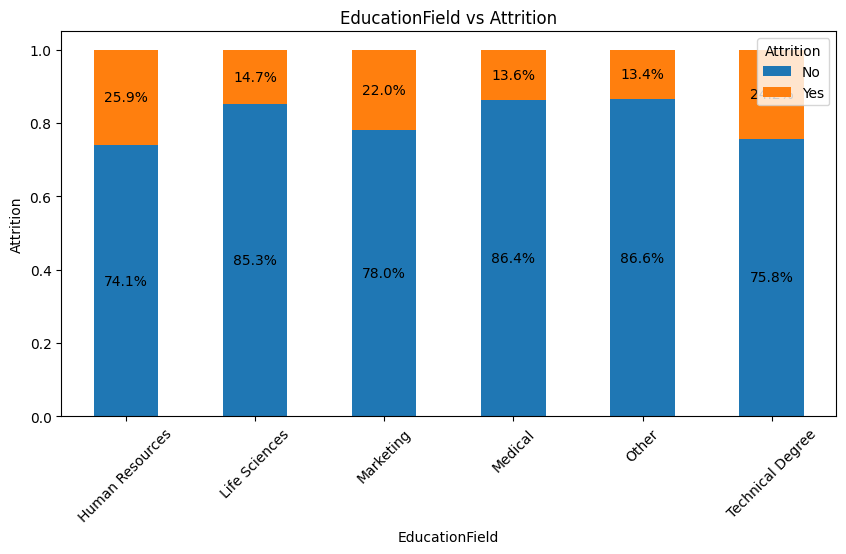

In [8]:
plot_attrition('EducationField')

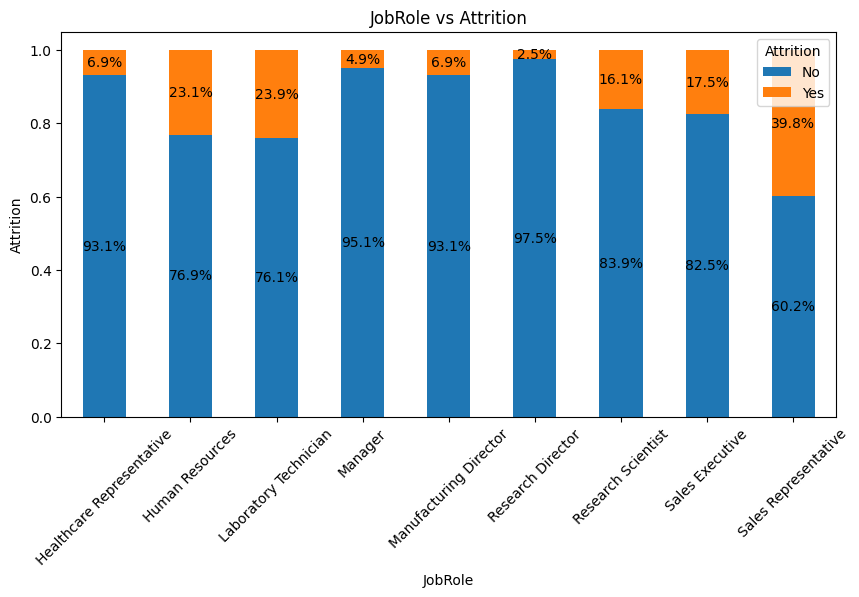

In [9]:
plot_attrition('JobRole')

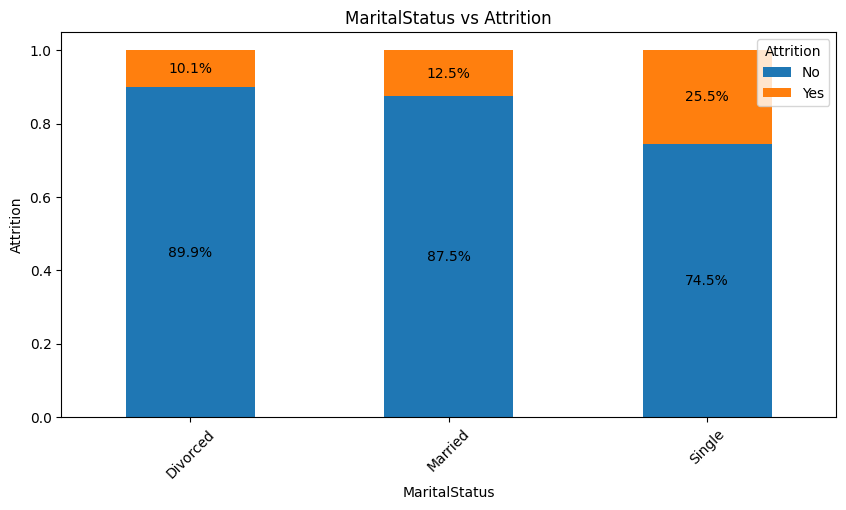

In [10]:
plot_attrition('MaritalStatus')

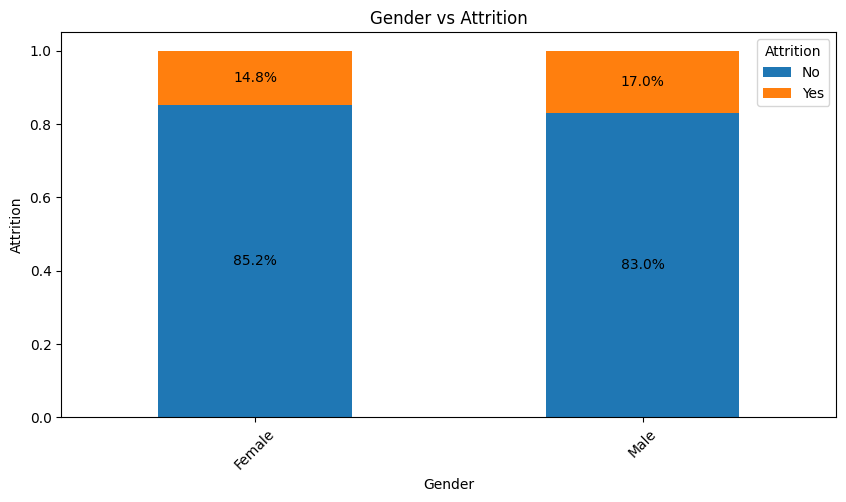

In [11]:
plot_attrition('Gender')

In [12]:
# One-Hot Encode Categorical Variables

df = df.join(pd.get_dummies(df['BusinessTravel'], prefix = 'BusinessTravel')).drop('BusinessTravel', axis = 1)
df = df.join(pd.get_dummies(df['Department'], prefix = 'Department')).drop('Department', axis = 1)
df = df.join(pd.get_dummies(df['EducationField'], prefix = 'Education')).drop('EducationField', axis = 1)
df = df.join(pd.get_dummies(df['JobRole'], prefix = 'Job')).drop('JobRole', axis = 1)
df = df.join(pd.get_dummies(df['MaritalStatus'])).drop('MaritalStatus', axis = 1)

In [13]:
# Binary Encode

df['Attrition'].replace({'Yes': 1, 'No': 0}, inplace = True)
df['Gender'].replace({'Male': 1, 'Female': 0}, inplace = True)
df['Over18'].replace({'Y': 1, 'N': 0}, inplace = True)
df['OverTime'].replace({'Yes': 1, 'No': 0}, inplace = True)

In [14]:
# Binary Encode the One-Hot Encoded Parameters

df.replace({True: 1, False: 0}, inplace = True)

array([[<AxesSubplot: title={'center': 'Age'}>,
        <AxesSubplot: title={'center': 'Attrition'}>,
        <AxesSubplot: title={'center': 'DailyRate'}>,
        <AxesSubplot: title={'center': 'DistanceFromHome'}>,
        <AxesSubplot: title={'center': 'Education'}>,
        <AxesSubplot: title={'center': 'EmployeeCount'}>,
        <AxesSubplot: title={'center': 'EmployeeNumber'}>],
       [<AxesSubplot: title={'center': 'EnvironmentSatisfaction'}>,
        <AxesSubplot: title={'center': 'Gender'}>,
        <AxesSubplot: title={'center': 'HourlyRate'}>,
        <AxesSubplot: title={'center': 'JobInvolvement'}>,
        <AxesSubplot: title={'center': 'JobLevel'}>,
        <AxesSubplot: title={'center': 'JobSatisfaction'}>,
        <AxesSubplot: title={'center': 'MonthlyIncome'}>],
       [<AxesSubplot: title={'center': 'MonthlyRate'}>,
        <AxesSubplot: title={'center': 'NumCompaniesWorked'}>,
        <AxesSubplot: title={'center': 'Over18'}>,
        <AxesSubplot: title={'center

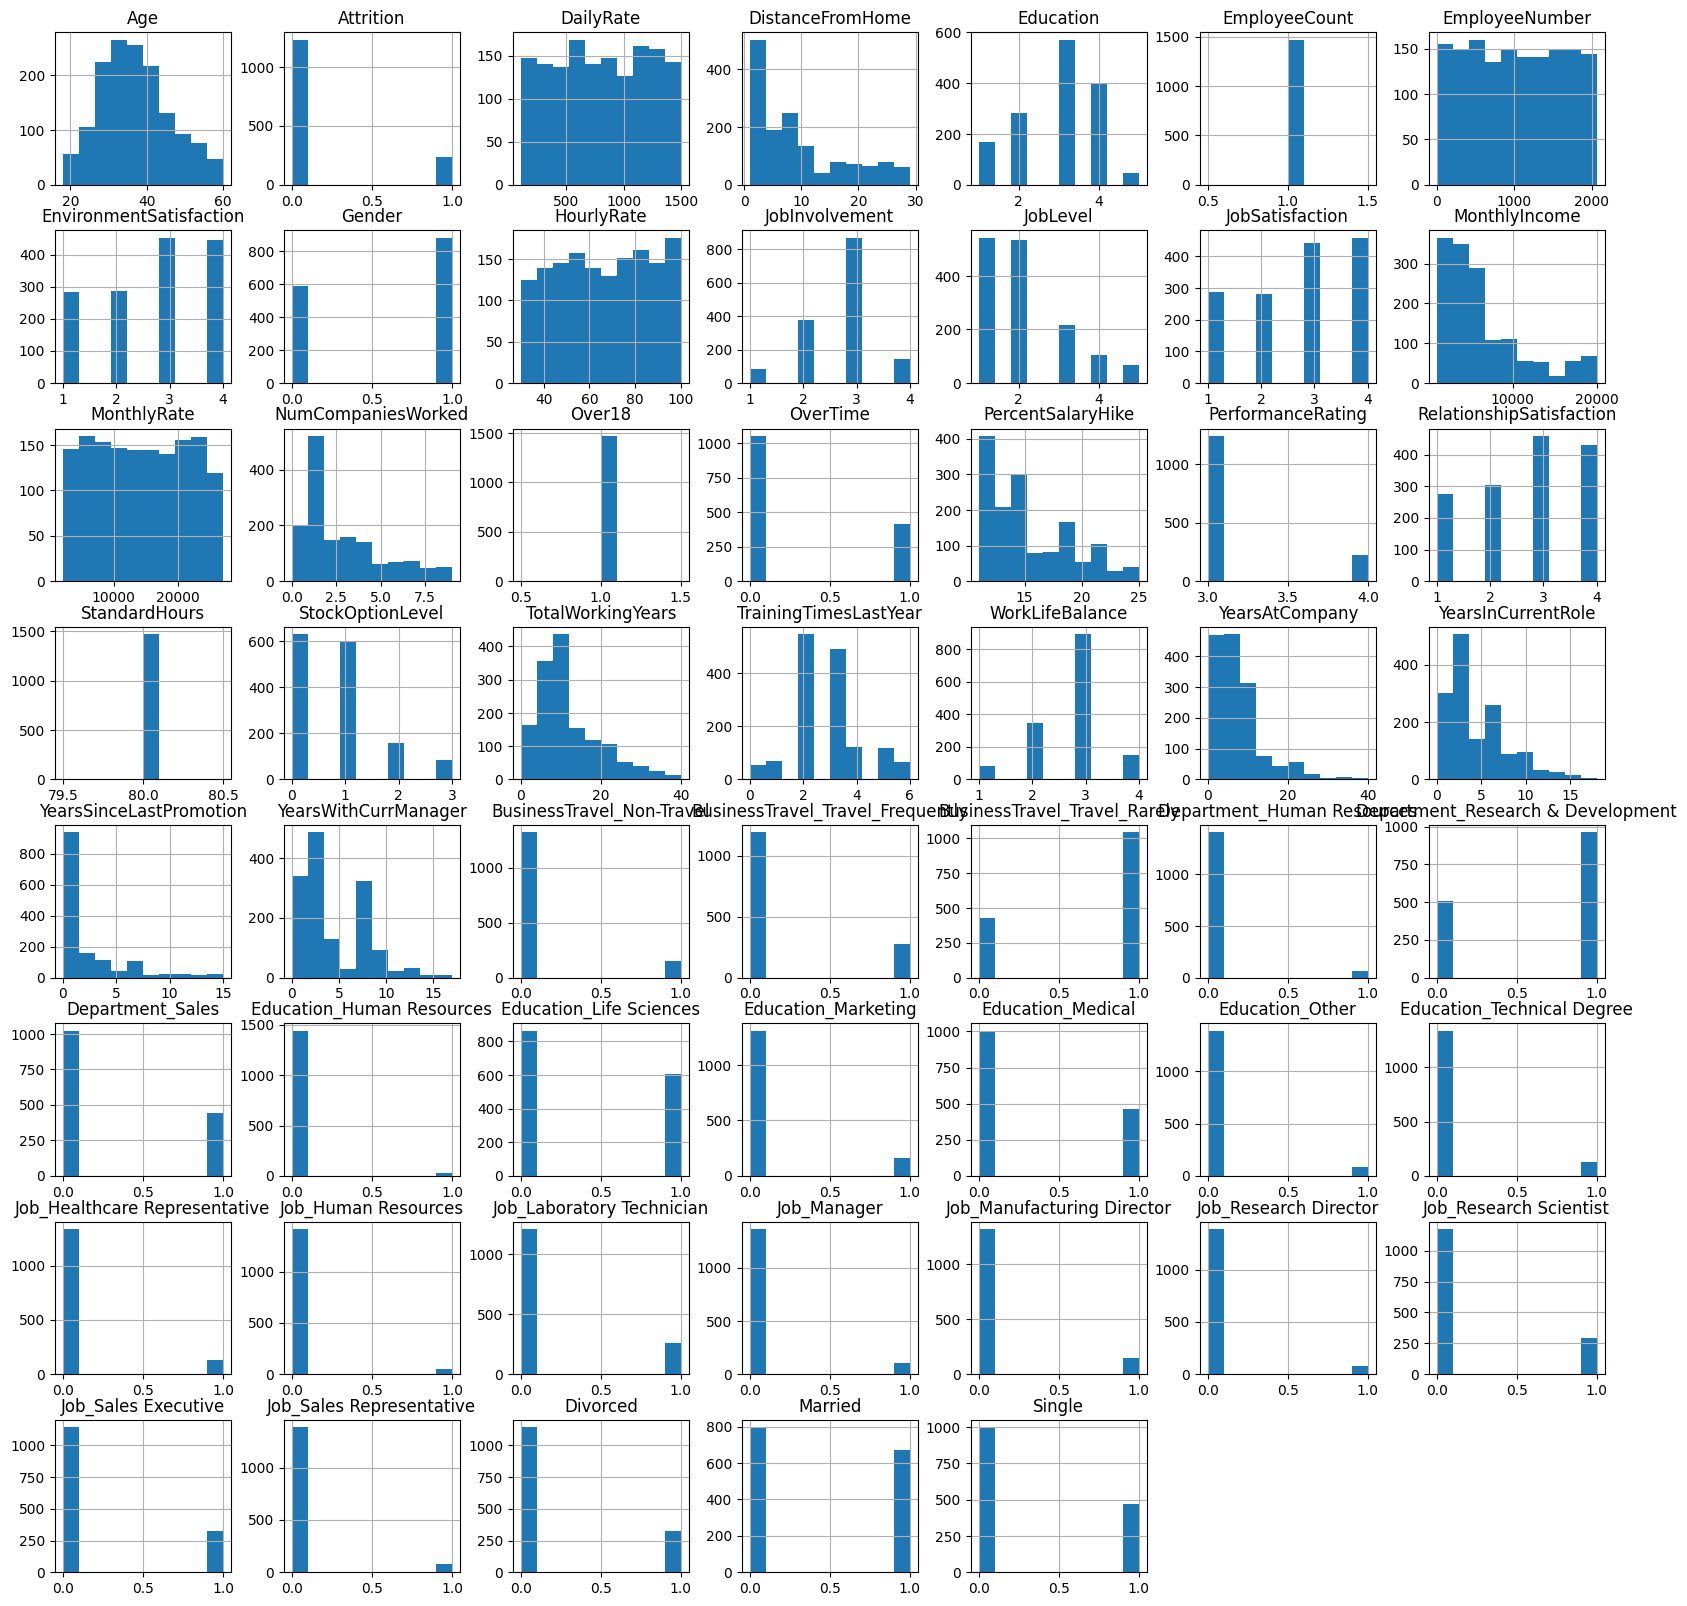

In [15]:
df.hist(figsize = (20, 20))

In [16]:
# Drop unncessary columns

df = df.drop(['EmployeeCount', 'Over18', 'StandardHours'], axis = 1) # Entire column has the same value
df = df.drop(['EmployeeNumber'], axis = 1) # Can be used as an identifier but we are using dataset indexing
df

,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,Education_Human Resources,Education_Life Sciences,Education_Marketing,Education_Medical,Education_Other,Education_Technical Degree,Job_Healthcare Representative,Job_Human Resources,Job_Laboratory Technician,Job_Manager,Job_Manufacturing Director,Job_Research Director,Job_Research Scientist,Job_Sales Executive,Job_Sales Representative,Divorced,Married,Single
0,41,1,1102,1,2,2,0,94,3,2,4,5993,19479,8,1,11,3,1,0,8,0,1,6,4,0,5,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,49,0,279,8,1,3,1,61,2,2,2,5130,24907,1,0,23,4,4,1,10,3,3,10,7,1,7,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,37,1,1373,2,2,4,1,92,2,1,3,2090,2396,6,1,15,3,2,0,7,3,3,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
3,33,0,1392,3,4,4,0,56,3,1,3,2909,23159,1,1,11,3,3,0,8,3,3,8,7,3,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,27,0,591,2,1,1,1,40,3,1,2,3468,16632,9,0,12,3,4,1,6,3,3,2,2,2,2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,0,884,23,2,3,1,41,4,2,4,2571,12290,4,0,17,3,3,1,17,3,3,5,2,0,3,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1466,39,0,613,6,1,4,1,42,2,3,1,9991,21457,4,0,15,3,1,1,9,5,3,7,7,1,7,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1467,27,0,155,4,3,2,1,87,4,2,2,6142,5174,1,1,20,4,2,1,6,0,3,6,2,0,3,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1468,49,0,1023,2,3,4,1,63,2,2,2,5390,13243,2,0,14,3,4,0,17,3,2,9,6,0,8,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0


In [17]:
# Standardize the dataset

scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
df

,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,Education_Human Resources,Education_Life Sciences,Education_Marketing,Education_Medical,Education_Other,Education_Technical Degree,Job_Healthcare Representative,Job_Human Resources,Job_Laboratory Technician,Job_Manager,Job_Manufacturing Director,Job_Research Director,Job_Research Scientist,Job_Sales Executive,Job_Sales Representative,Divorced,Married,Single
0,0.547619,1.0,0.715820,0.000000,0.25,0.333333,0.0,0.914286,0.666667,0.25,1.000000,0.262454,0.698053,0.888889,1.0,0.000000,0.0,0.000000,0.000000,0.200,0.000000,0.000000,0.150,0.222222,0.000000,0.294118,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.738095,0.0,0.126700,0.250000,0.00,0.666667,1.0,0.442857,0.333333,0.25,0.333333,0.217009,0.916001,0.111111,0.0,0.857143,1.0,1.000000,0.333333,0.250,0.500000,0.666667,0.250,0.388889,0.066667,0.411765,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.452381,1.0,0.909807,0.035714,0.25,1.000000,1.0,0.885714,0.333333,0.00,0.666667,0.056925,0.012126,0.666667,1.0,0.285714,0.0,0.333333,0.000000,0.175,0.500000,0.666667,0.000,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.357143,0.0,0.923407,0.071429,0.75,1.000000,0.0,0.371429,0.666667,0.00,0.666667,0.100053,0.845814,0.111111,1.0,0.000000,0.0,0.666667,0.000000,0.200,0.500000,0.666667,0.200,0.388889,0.200000,0.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.214286,0.0,0.350036,0.035714,0.00,0.000000,1.0,0.142857,0.666667,0.00,0.333333,0.129489,0.583738,1.000000,0.0,0.071429,0.0,1.000000,0.333333,0.150,0.500000,0.666667,0.050,0.111111,0.133333,0.117647,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,0.428571,0.0,0.559771,0.785714,0.25,0.666667,1.0,0.157143,1.000000,0.25,1.000000,0.082254,0.409396,0.444444,0.0,0.428571,0.0,0.666667,0.333333,0.425,0.500000,0.666667,0.125,0.111111,0.000000,0.176471,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1466,0.500000,0.0,0.365784,0.178571,0.00,1.000000,1.0,0.171429,0.333333,0.50,0.000000,0.472986,0.777474,0.444444,0.0,0.285714,0.0,0.000000,0.333333,0.225,0.833333,0.666667,0.175,0.388889,0.066667,0.411765,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1467,0.214286,0.0,0.037938,0.107143,0.50,0.333333,1.0,0.814286,1.000000,0.25,0.333333,0.270300,0.123670,0.111111,1.0,0.642857,1.0,0.333333,0.333333,0.150,0.000000,0.666667,0.150,0.111111,0.000000,0.176471,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1468,0.738095,0.0,0.659270,0.035714,0.50,1.000000,1.0,0.471429,0.333333,0.25,0.333333,0.230700,0.447661,0.222222,0.0,0.214286,0.0,1.000000,0.000000,0.425,0.500000,0.333333,0.225,0.333333,0.000000,0.470588,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [18]:
corr_matrix=df.corr()
stacked_corr = corr_matrix.stack()
filtered_corr = stacked_corr[abs(stacked_corr) > 0.95]
filtered_corr = filtered_corr[filtered_corr.index.get_level_values(0) != filtered_corr.index.get_level_values(1)]

print("Combinations with correlation greater than 0.94 (absolute value):")
filtered_corr


Combinations with correlation greater than 0.94 (absolute value):


JobLevel       MonthlyIncome    0.9503
MonthlyIncome  JobLevel         0.9503
dtype: float64

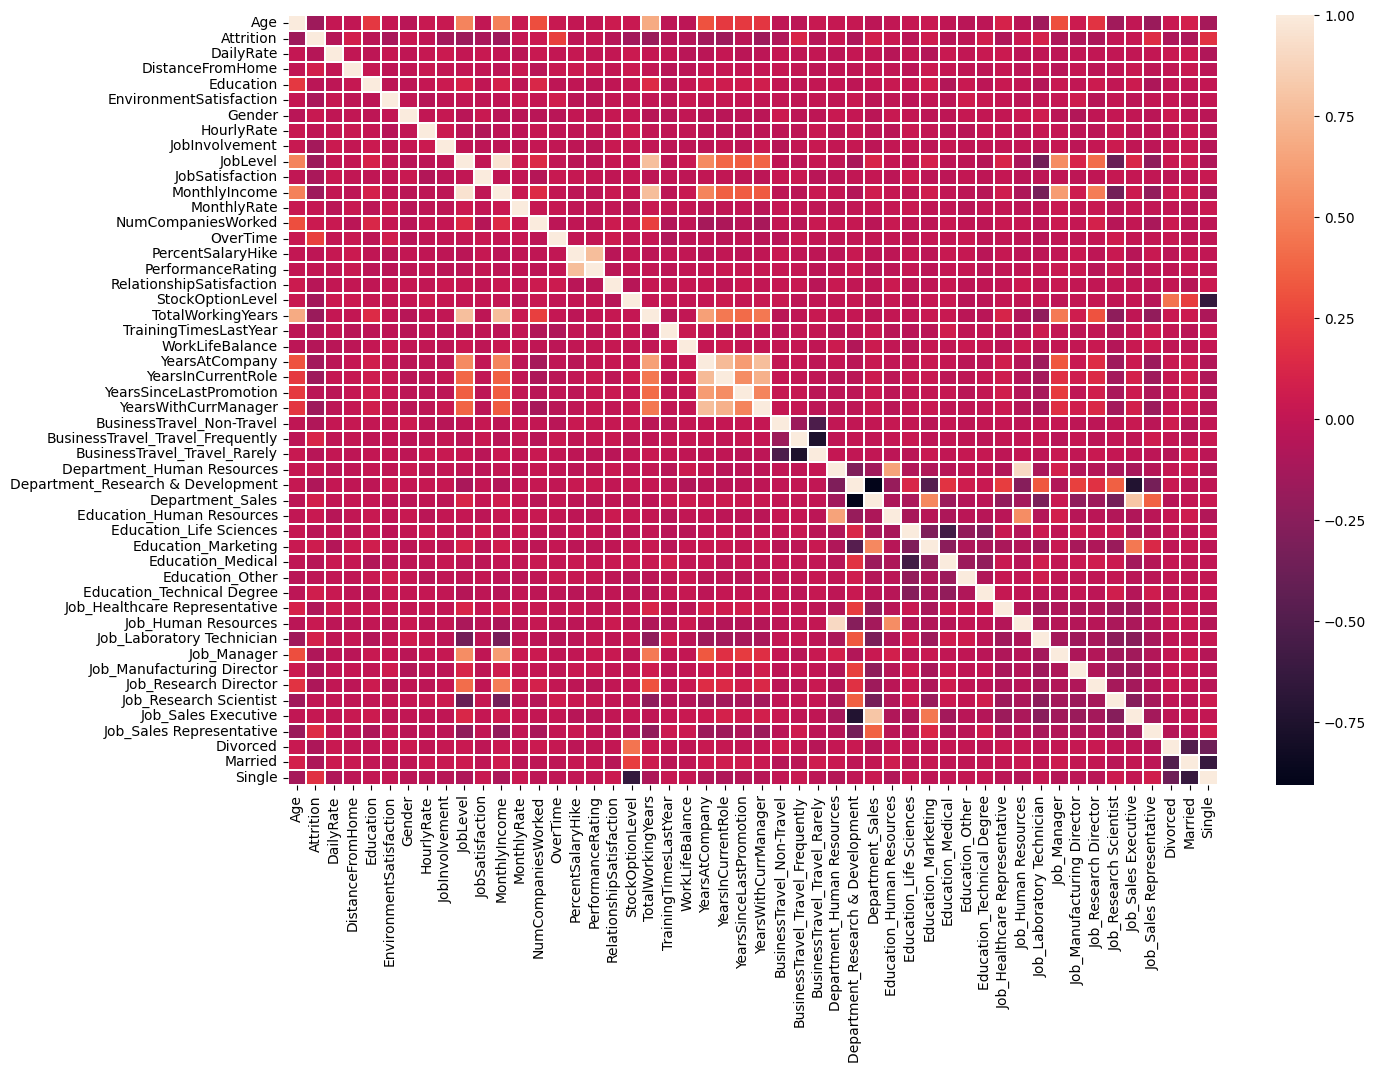

In [19]:
fig,ax=plt.subplots(figsize=(15,10))
ax=sns.heatmap(corr_matrix,
               linewidths=0.2,
               fmt=".1f"
              )
df = df.drop(['JobLevel'], axis = 1) # Remove extremely correlated columns

## Training / Testing

In [89]:
def training_testing(df, new_model, batch_size ,title, scores_title, verbose = False):
  # Split the dataset

  X, y = df.drop('Attrition', axis = 1), df['Attrition']

  start = time.time()
  test_scores = []
  train_scores = []

  best_score = 0
  optimal_model = None
  optimal_X_test, optimal_y_test = None, None
  for i in range(batch_size):
    model = clone(new_model)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    model.fit(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    test_scores.append(test_acc)
    train_scores.append(model.score(X_train, y_train))
    
    if test_acc > best_score:
        best_score = test_acc
        optimal_model = model
        optimal_X_test = X_test
        optimal_y_test = y_test

    
  end = time.time()
  mean_accuracy = sum(test_scores) / batch_size


  if verbose == True:
    print("############################ " + title + " ############################ \n")
    print('Total Training Time: ' + str(end - start))
    print(classification_report(optimal_y_test, optimal_model.predict(optimal_X_test)))
    print("Best Test Accuracy: ", best_score)
    print('Mean Train Accuracy: ' , sum(train_scores) / batch_size)
    print('Mean Test Accuracy: ' , mean_accuracy)
    print("########################################################################################################################## \n")
      

  return optimal_model, {scores_title: best_score}, mean_accuracy


def compare_models(df, models, batch_size, verbose):
    results = []
    for name, model in models.items():
        trained_model, metric , Mean_accuracy = training_testing(df, 
                                                 model, 
                                                 batch_size,
                                                 title = f"All Features - {name}",
                                                 scores_title = name,
                                                 verbose = verbose)
        results.append({"Model": name,
                        "Best_Accuracy": metric[name],
                        "Trained_Model": trained_model,
                        "Mean_Accuracy": Mean_accuracy
                       })
    
    model_results = pd.DataFrame(results)
    return model_results

In [90]:
# Random Forest Classifier
rt_clf = RandomForestClassifier(n_estimators = 150, n_jobs = -1)

# Decision Tree Classifier
dt_clf = DecisionTreeClassifier()

# Logistic Regression Classifier
log_reg = LogisticRegression('l2', tol = 0.01,  C = 10, solver = 'liblinear')
      # tol = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1] # Ideal tol = 0.01
      # C = [0.01, 0.1, 1, 10, 100] # Ideal C = 10

# K Nearest Neighbors
knn_clf = KNeighborsClassifier(16, weights = 'distance', n_jobs = -1, p = 1)
      # k = list(range(1, 20)) # Ideal - K = 16

# Support Vector Machine
svm_clf = svm.SVC(C = 50, degree = 1, tol = 1, kernel = 'poly')
      # c = [0.001, 0.01, 0.1, 1, 10, 100] # Ideal C = 50
      # degree = list(range(1,10)) # Ideal degree = 1
      # tol = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1] # Ideal tol = 1

# Gaussian Bernoulli Distribution Classifier
nb_clf = GaussianNB(var_smoothing  = 1)
      # var_s = [(10 * 10**(-x)) for x in range(11)] # Ideal var_smoothing = 1



In [105]:
# Custom Validation and optimal parameters

models = {
    "Random_Forest": rt_clf,
    "Decision_Tree": dt_clf,
    "Logistic_Regression": log_reg,
    "KNN": knn_clf,
    "SVM": svm_clf,
    "Naive_Bayes": nb_clf
}

model_results = compare_models(df, models, batch_size=20, verbose=False)

In [106]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=model_results["Model"],
    y=model_results["Best_Accuracy"],
    mode='lines+markers+text',
    text=[f"{acc*100:.1f}%" for acc in model_results["Best_Accuracy"]],
    textposition="top center",
    name="Best Accuracy",
    line=dict(color="royalblue", width=3)
))

if "Mean_Accuracy" in model_results.columns:
    fig.add_trace(go.Scatter(
        x=model_results["Model"],
        y=model_results["Mean_Accuracy"],
        mode='lines+markers+text',
        text=[f"{acc*100:.1f}%" for acc in model_results["Mean_Accuracy"]],
        textposition="bottom center",
        name="Mean Accuracy",
        line=dict(color="orange", width=3, dash="dash")
    ))

fig.update_layout(
    title="Model Comparison - Best vs Mean Accuracy",
    xaxis_title="Model",
    yaxis_title="Accuracy",
    yaxis_tickformat=".0%",
    hovermode="x unified"
)
fig.show(renderer="iframe")
fig.show()


## AUTOML

In [40]:
X, y = df.drop('Attrition', axis = 1), df['Attrition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
train_time_mins = 5


automl_clf = AutoML(task = "classification",
                   n_jobs = -1,
                   time_budget = train_time_mins * 60,
                   max_iter = 1000,
                   ensemble = True,
                    eval_method = 'cv',
                   n_splits = 5,
                    early_stop = True,
                    verbose = 1
                   )


In [41]:
automl_clf.fit(X_train, y_train)
y_hat = automl_clf.predict(X_test)

In [33]:
print('Best ML leaner:', automl_clf.best_estimator)
print('Best hyperparmeter config:', automl_clf.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl_clf.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl_clf.best_config_train_time))

Best ML leaner: sgd
Best hyperparmeter config: {'penalty': 'None', 'alpha': 0.009610714863022393, 'l1_ratio': 0.15555346668299963, 'epsilon': 0.1, 'learning_rate': 'constant', 'eta0': 0.009486024665305489, 'power_t': 0.36099605543145896, 'average': False, 'loss': 'modified_huber'}
Best accuracy on validation data: 0.8318
Training duration of best run: 1.901 s


In [36]:
y_pred = automl_clf.predict(X_test)
# print('Predicted labels', y_pred)
# print('True labels', y_test)
y_pred_proba = automl_clf.predict_proba(X_test)[:,1]

from flaml.ml import sklearn_metric_loss_score
print('accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred, y_test))
print('roc_auc', '=', 1 - sklearn_metric_loss_score('roc_auc', y_pred_proba, y_test))
print('log_loss', '=', sklearn_metric_loss_score('log_loss', y_pred_proba, y_test))

accuracy = 0.8741496598639455
roc_auc = 0.8117283950617284
log_loss = 0.35335417070880737


In [ ]:
# important_features = pd.Series(rt_clf.feature_importances_, index=X.columns)
# important_features.nlargest(30).plot(kind='barh')
# important_features.nlargest(30).index

# ## Train only using the most impactful features

# mi_df = df[important_features.nlargest(30).index].join(df['Attrition'])
# mi_df


# ## Split the dataset

# mi_X, mi_y = mi_df.drop('Attrition', axis = 1), mi_df['Attrition']
# mi_X_train, mi_X_test, mi_y_train, mi_y_test = train_test_split(mi_X, mi_y, test_size = 0.2)


# ## Retrain and check accuracy

# mi_rt_clf = training_testing(mi_X_train, mi_y_train, mi_X_test, mi_y_test, RandomForestClassifier(n_estimators = 150, n_jobs = -1), batch_size, "Preprocessed Dataset - Most Important Features")